# Setup

In [2]:
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os
from matplotlib.patches import Polygon
import copy
import pickle
from scipy.stats import norm,wilcoxon
import statistics


In [3]:
# plotting parameters
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999',
              BLUE = '#1f77b4',
              ORANGE = '#ff7f0e',
              GREEN = '#2ca02c',
              RED = '#d62728',
              PURPLE = '#9467bd',
              GOLD = '#FDB119') #default colors
              # D = dominant = right; N = nondominant = left

yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

bfill = list(matplotlib.colors.to_rgba(colors['BLUE']))
bfill[-1] = 0.3

font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [4]:
a_file = open("HCPS.pkl", "rb") #remember to close afterwards
HCPS = pickle.load(a_file)
a_file.close()

b_file = open("DATA.pkl", "rb") #remember to close afterwards
DATA = pickle.load(b_file)
b_file.close()

c_file = open("TF.pkl", "rb") #remember to close afterwards
TF = pickle.load(c_file)
c_file.close()

d_file = open("SIM.pkl", "rb") #remember to close afterwards
SIM = pickle.load(d_file)
d_file.close()

lqg_file = open("LQG_SIM.pkl", "rb") #remember to close afterwards
LQG_SIM = pickle.load(lqg_file)
lqg_file.close()

In [5]:
# Data analysis
def FFT(data,N):
  return fft.fft(data)/N

def IFFT(data,N):
  return (fft.ifft(data)*N).real
  
M = lambda s : 1/(s**2 + s) #2nd order machine

num_cond = 7 #number of conditions
participants_num = len(HCPS.keys())

#number of trials for each condition
trialnum = [0] * num_cond 
for c in range(num_cond):
  trialnum[c] = len(HCPS['subject0']['condition'+str(c)].keys())         #number of data trials, trial0 ~ trial3

#parameters (same for all three conditions)
fs = 60                               #pygame update rate 60 Hz
base_freq = 0.05                      #1/20 Hz
N = len(HCPS['subject0']['condition0']['trial0']['time_'])    #data length
xf_all = fft.fftfreq(N, 1./ fs)       #freq (x-axis) both + and - terms
xf = fft.fftfreq(N, 1./ fs)[:N//2]    #freq (x-axis) positive-frequency terms
M_h = M(1.j*2*np.pi*xf_all)           #M_hat = 1/ ((jw)^2 + (jw))
t = HCPS['subject0']['condition0']['trial0']['time_']         #time
prime = np.asarray([2, 3, 5, 7, 
                    11, 13, 17, 19])  #prime numbers
stimulated_index = prime*2 #array([ 4,  6, 10, 14, 22, 26, 34, 38])
stimulated_freq = prime*base_freq

T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

<ipython-input-5-cf8719837387>:8: RuntimeWarning: divide by zero encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine
<ipython-input-5-cf8719837387>:8: RuntimeWarning: invalid value encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine


In [6]:
def boxplot_colors(bp0,bp1,bp2,bp3,bp4,bp5,bp6): # fill in colors
  for i in range(num_cond):
    if i == 0: bp = bp0; box_colors = colors['r']
    elif i == 1: bp = bp1; box_colors = colors['g']
    elif i == 2: bp = bp2; box_colors = colors['u']
    elif i == 3: bp = bp3; box_colors = colors['u25']
    elif i == 4: bp = bp4; box_colors = colors['u75']
    elif i == 5: bp = bp5; box_colors = colors['r']
    else: bp = bp6; box_colors = colors['g']
    num_boxes = 1
    medians = np.empty(num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(num_cond):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        ax.add_patch(Polygon(box_coords, facecolor=box_colors))
    # change color of medians
    for median in bp['medians']: median.set(color ='red')

In [7]:
def BOXPLOT(data0, title0 ,data1 = None, title1 = None, ylimit0 = None, ylimit1= None, EMGplot = False, Sliderplot = False): # can plot one or two plots
    '''
    data0 and data1: list of 7 arrays, [cond0, cond1, ... cond6]
    '''
    
    # pos = np.array(range(num_cond))+1
    # xticks = pos
    # xticklabels = ['Slider','EMG','50%','25%','75%','Slider2','EMG2']
    labels = ['100:0','0:100','50:50','75:25','25:75','100:0','0:100'] #slider : EMG

    boxcolors = ['white', 'black', 'darkgrey','lightgrey','dimgrey','white', 'black',]

    if data1 != None: 
        fig,axs = plt.subplots(1, 2,figsize=(10,5)) 

        # subplot 0
        ax = axs[0]
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
            patch.set_facecolor(color)

        ax.title.set_text(title0)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None: 
            ax.set_ylim(0,ylimit0)
            
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

        # subplot 1
        ax = axs[1]
        bplot = ax.boxplot(data1, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)

        ax.title.set_text(title1)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit1 is not None:
            ax.set_ylim(0,ylimit1)
        
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

    else: 
        fig,axs = plt.subplots(1, 1,figsize=(5,5)) 
        ax = axs
        # for c in range(num_cond):
        #     bplot = ax.boxplot(data0[c], positions = [pos[c]], widths = 0.5,patch_artist=True)
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        
        # fill with colors
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)

        # ax.set_xticks(xticks)
        # ax.set_xticklabels(xticklabels)
        ax.title.set_text(title0) #r'$MSE_{time}$'
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None:
            ax.set_ylim(0,ylimit0)

        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)


    # plt.tight_layout()
    # plt.show()
    return fig,axs

In [8]:
#box plot of only 5 elements
def BOXPLOT5(data0, title0 ,data1 = None, title1 = None, ylimit0 = None, ylimit1= None, EMGplot = False, Sliderplot = False): # can plot one or two plots
    '''
    data0 and data1: list of 5 arrays, [cond0, cond1, ... cond4]
    '''
    
    # pos = np.array(range(num_cond))+1
    # xticks = pos
    # xticklabels = ['Slider','EMG','50%','25%','75%','Slider2','EMG2']
    labels = ['100:0','0:100','50:50','75:25','25:75'] #slider : EMG

    boxcolors = ['white', 'black', 'darkgrey','lightgrey','dimgrey']

    if data1 != None: 
        fig,axs = plt.subplots(1, 2,figsize=(10,5)) 

        # subplot 0
        ax = axs[0]
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
            patch.set_facecolor(color)

        ax.title.set_text(title0)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None: 
            ax.set_ylim(0,ylimit0)
            
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

        # subplot 1
        ax = axs[1]
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)

        ax.title.set_text(title1)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit1 is not None:
            ax.set_ylim(0,ylimit1)
        
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

    else: 
        fig,axs = plt.subplots(1, 1,figsize=(5,5)) 
        ax = axs
        # for c in range(num_cond):
        #     bplot = ax.boxplot(data0[c], positions = [pos[c]], widths = 0.5,patch_artist=True)
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        
        # fill with colors
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)

        # ax.set_xticks(xticks)
        # ax.set_xticklabels(xticklabels)
        ax.title.set_text(title0) #r'$MSE_{time}$'
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None:
            ax.set_ylim(0,ylimit0)

        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)


    # plt.tight_layout()
    # plt.show()
    return fig,axs

## stats functions

In [9]:

# Wilcoxon signed-rank test:  tests the null hypothesis that two related paired samples come from the same distribution

def WilcoxonTest(all_data):
    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = wilcoxon(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag
#T-test: test for the null hypothesis that two related or repeated samples have identical average (expected) values
def TTest(all_data):
    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = ttest_rel(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag
# number of trials to look at of each condition: (ex: last 4)
# last_trial = [4,4,8,8,8,4,4]
# last_trial = [2,2,4,4,4,2,2]
# last_trial = [2,2,2,2,2,2,2]
# last_trial = [8,8,10,10,10,2,2]
# last_trial = [5,5,5,5,5,4,4]
last_trial = [5,5,5,5,5,2,2]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
# first_freq = [0,1,2,3,4,5,6,7]
first_freq = [0,1]

# plot_title = 'first 2 freqs' #'all freqs'

# Fusion condition

## U_emg & U_slider (stim+nonstim) of all trials all participants

In [142]:
# number of trials to look at of each condition: (ex: last 4)
# last_trial = [4,4,8,8,8,4,4]
# last_trial = [2,2,4,4,4,2,2]
# last_trial = [8,8,10,10,10,2,2]
# last_trial = [2,2,2,2,2,2,2]
last_trial = [5,5,5,5,5,2,2]
# last_trial = [5,5,5,5,5,4,4]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
first_freq = [0,1,2,3,4,5,6,7]
first_freq = [0,1]

plot_title = 'first 2 freqs' #'all freqs'

<>:43: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:45: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-143-e5f3938f19da>:43: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if c is not 0:
<ipython-input-143-e5f3938f19da>:45: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if c is not 1:


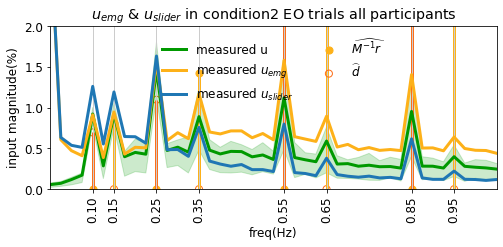

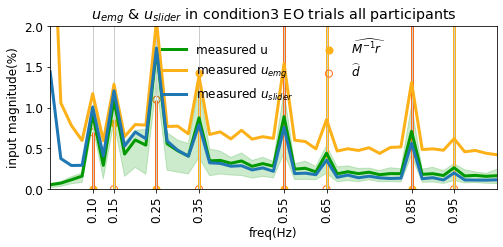

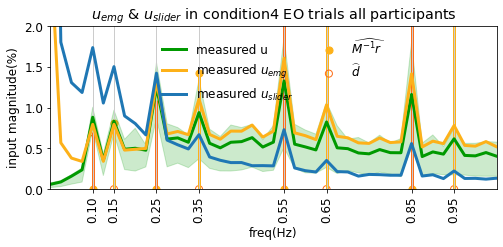

In [143]:
for c in [2,3,4]: #condition number
    #measured data
    # ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
    # dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput

    in_all = []
    in0_all = []
    in1_all = []

    for p in range(participants_num): #subject number
        for i in range(0,trialnum[2],2): #EO trials
            in_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput ) #measured
            in0_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i]/scaleInput ) #measured
            in1_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u1'][i]/scaleInput ) #measured

    plt.figure(figsize=(8, 3))
    for ii in prime: # prime multiples of a base frequency (1/20Hz)
        plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')

    u_measure = [np.abs(FFT((in_all[i])*scaleInput,N)[:N//2]) for i in range(participants_num*(trialnum[c]//2))] #mag of FFT(uFB)
    u_mean = np.mean(u_measure,axis =0)
    u_75 = np.percentile(u_measure,75,axis =0)
    u_25 = np.percentile(u_measure,25,axis =0)

    u0_measure = [np.abs(FFT((in0_all[i])*scaleInput,N)[:N//2]) for i in range(participants_num*(trialnum[c]//2))] #mag of FFT(uFB)
    u0_mean = np.mean(u0_measure,axis =0)
    u0_75 = np.percentile(u0_measure,75,axis =0)
    u0_25 = np.percentile(u0_measure,25,axis =0)

    u1_measure = [np.abs(FFT((in1_all[i])*scaleInput,N)[:N//2]) for i in range(participants_num*(trialnum[c]//2))] #mag of FFT(uFB)
    u1_mean = np.mean(u1_measure,axis =0)
    u1_75 = np.percentile(u1_measure,75,axis =0)
    u1_25 = np.percentile(u1_measure,25,axis =0)

    WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
    D = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][i][:N//2] )
    plt.scatter(xf[stimulated_index],100*WR[stimulated_index], color=colors['r'],label=r'$\widehat{M^{-1}r}$',s=50)
    plt.scatter(xf[stimulated_index],100*D[stimulated_index], color=colors['d'],label=r'$\widehat{d}$',facecolors='none',s=50)
    plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*WR[stimulated_index],color=colors['r'],linewidth = 3)
    plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*D[stimulated_index],color=colors['d'],linewidth = 3)
    
    plt.plot(xf,u_mean*100, color=colors['u'],label='measured u',linewidth = 3)
    if c is not 0:
        plt.plot(xf,u0_mean*100, color=colors['r'],label=r'measured $u_{emg}$',linewidth = 3)
    if c is not 1:
        plt.plot(xf,u1_mean*100, color=colors['BLUE'],label=r'measured $u_{slider}$',linewidth = 3)

    plt.fill_between(xf,u_25*100,u_75*100, facecolor=ufill,edgecolor=colors['u'],alpha=0.2)
    plt.xlim((0,21*base_freq))
    plt.ylim((0,2))

    plt.xlabel('freq(Hz)')
    plt.ylabel('input magnitude(%)')
    plt.xticks(prime*0.05,rotation = 90)
    # plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.legend( loc='upper center', ncol=2, frameon=False)
    plt.title(r'$u_{emg}$ & $u_{slider}$ in condition'+str(c)+' EO trials all participants')
    plt.show()

## U_emg & U_slider below corssover

In [144]:
Unorm_emg = {}
Unorm_slider = {}

for p in range(participants_num): 
    Unorm_emg['subject'+str(p)] = {}
    Unorm_slider['subject'+str(p)] = {}
    for c in [2,3,4]: 
        U_emg = np.mean(np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:])[:,stimulated_index[0:2]]), axis = 0) #average UX below corssover of all trials 
        U_slider = np.mean(np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:])[:,stimulated_index[0:2]]), axis = 0)
        Unorm_emg['subject'+str(p)]['condition'+str(c)] = LA.norm(U_emg) 
        Unorm_slider['subject'+str(p)]['condition'+str(c)] = LA.norm(U_slider) 

Uvalues_e = [] # 7 conditions x (15participants * i/2 trials)
for c in [2,3,4]:
    values_ = []
    for p in range(participants_num):
        values_.append(Unorm_emg['subject'+str(p)]['condition'+str(c)]) #average of all trials of a participant of a condition
    Uvalues_e.append(values_) #each participant 

Uvalues_s = [] # 7 conditions x (15participants * i/2 trials)
for c in [2,3,4]:
    values_ = []
    for p in range(participants_num):
        values_.append(Unorm_slider['subject'+str(p)]['condition'+str(c)]) #average of all trials of a participant of a condition
    Uvalues_s.append(values_) #each participant 

U_emg_below = Uvalues_e
U_slider_below = Uvalues_s

In [145]:
# # u_emg & u_slider below corssover of all participnats & all trials
# U_emg_below = []
# U_slider_below = []
# for c in [2,3,4]:
#     U_emg = []
#     U_slider = []
#     for p in range(participants_num): 
#         for i in range(last_trial[c]):
#             U_emg.append( LA.norm(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][i])[stimulated_index[0:2]]) )
#             U_slider.append( LA.norm(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:][i])[stimulated_index[0:2]]) )
#     U_emg_below.append(U_emg)
#     U_slider_below.append(U_slider)

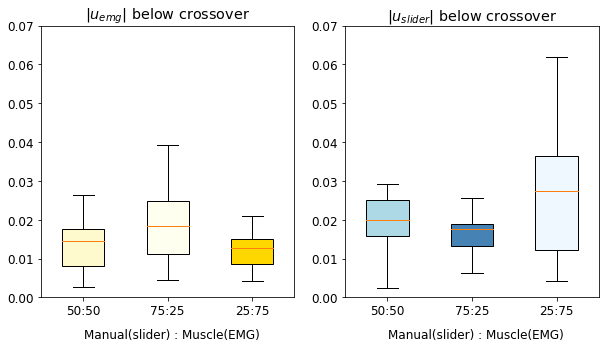

In [146]:
labels = ['50:50','75:25','25:75'] #slider : EMG

# boxcolors = ['darkgrey','lightgrey','dimgrey']
fig,axs = plt.subplots(1, 2,figsize=(10,5)) 

# subplot 0
ax = axs[0]
boxcolors = ['lemonchiffon','ivory','gold']
bplot = ax.boxplot(U_emg_below, widths = 0.5,patch_artist=True,labels=labels)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)

ax.title.set_text(r'$|u_{emg}|$ below crossover')
# ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
ax.set_ylim(0,0.07)
    
ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

# subplot 1
ax = axs[1]
boxcolors = ['lightblue','steelblue','aliceblue']
bplot = ax.boxplot(U_slider_below, widths = 0.5,patch_artist=True,labels=labels)
for patch, color in zip(bplot['boxes'], boxcolors):
    patch.set_facecolor(color)

ax.title.set_text(r'$|u_{slider}|$ below crossover')
# ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
ax.set_ylim(0,0.07)

ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

In [147]:
w, p = wilcoxon(U_emg_below[0],U_slider_below[0]) #**
w,p

(32.0, 0.12054443359375)

In [148]:
w, p = wilcoxon(U_emg_below[1],U_slider_below[1]) #**
w,p

(56.0, 0.846923828125)

In [149]:
w, p = wilcoxon(U_emg_below[2],U_slider_below[2]) #**
w,p

(22.0, 0.0301513671875)

## U_emg & U_slider above corssover

In [150]:
# U_emg & U_slider above corssover
Unorm_emg = {}
Unorm_slider = {}

for p in range(participants_num): 
    Unorm_emg['subject'+str(p)] = {}
    Unorm_slider['subject'+str(p)] = {}
    for c in [2,3,4]: 
        U_emg = np.mean(np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:])[:,stimulated_index[2:8]]), axis = 0) #average UX below corssover of all trials 
        U_slider = np.mean(np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:])[:,stimulated_index[2:8]]), axis = 0)
        Unorm_emg['subject'+str(p)]['condition'+str(c)] = LA.norm(U_emg) 
        Unorm_slider['subject'+str(p)]['condition'+str(c)] = LA.norm(U_slider) 

Uvalues_e = [] # 7 conditions x (15participants * i/2 trials)
for c in [2,3,4]:
    values_ = []
    for p in range(participants_num):
        values_.append(Unorm_emg['subject'+str(p)]['condition'+str(c)]) #average of all trials of a participant of a condition
    Uvalues_e.append(values_) #each participant 

Uvalues_s = [] # 7 conditions x (15participants * i/2 trials)
for c in [2,3,4]:
    values_ = []
    for p in range(participants_num):
        values_.append(Unorm_slider['subject'+str(p)]['condition'+str(c)]) #average of all trials of a participant of a condition
    Uvalues_s.append(values_) #each participant 

U_emg_above = Uvalues_e
U_slider_above = Uvalues_s

In [151]:
# # u_emg & u_slider above corssover of all participnats & all trials
# U_emg_above = []
# U_slider_above = []
# for c in [2,3,4]:
#     U_emg = []
#     U_slider = []
#     for p in range(participants_num): 
#         for i in range(last_trial[c]):
#             U_emg.append( LA.norm(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][i])[stimulated_index[2:8]]) )
#             U_slider.append( LA.norm(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:][i])[stimulated_index[2:8]]) )
#     U_emg_above.append(U_emg)
#     U_slider_above.append(U_slider)

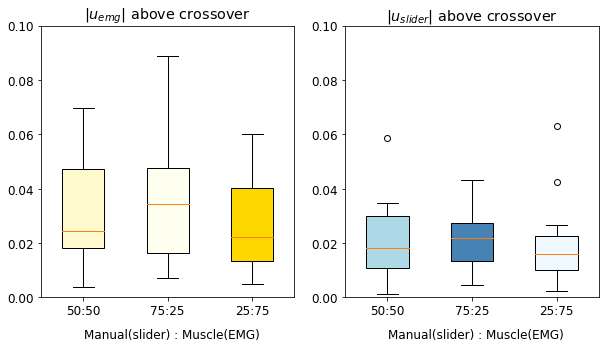

In [152]:
labels = ['50:50','75:25','25:75'] #slider : EMG

# boxcolors = ['darkgrey','lightgrey','dimgrey']
fig,axs = plt.subplots(1, 2,figsize=(10,5)) 

# subplot 0
ax = axs[0]
boxcolors = ['lemonchiffon','ivory','gold']
bplot = ax.boxplot(U_emg_above, widths = 0.5,patch_artist=True,labels=labels)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)

ax.title.set_text(r'$|u_{emg}|$ above crossover')
# ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
ax.set_ylim(0,0.1)
    
ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

# subplot 1
ax = axs[1]
boxcolors = ['lightblue','steelblue','aliceblue']
bplot = ax.boxplot(U_slider_above, widths = 0.5,patch_artist=True,labels=labels)
for patch, color in zip(bplot['boxes'], boxcolors):
    patch.set_facecolor(color)

ax.title.set_text(r'$|u_{slider}|$ above crossover')
# ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
ax.set_ylim(0,0.1)

ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

In [153]:
w, p = wilcoxon(U_emg_above[0],U_slider_above[0])
w,p

(37.0, 0.207763671875)

In [154]:
w, p = wilcoxon(U_emg_above[1],U_slider_above[1])
w,p

(31.0, 0.10699462890625)

In [155]:

w, p = wilcoxon(U_emg_above[2],U_slider_above[2])
w,p

(38.0, 0.22930908203125)

## U_emg & U_slider below/above corssover (all fusion cond together)

(0.0, 0.1)

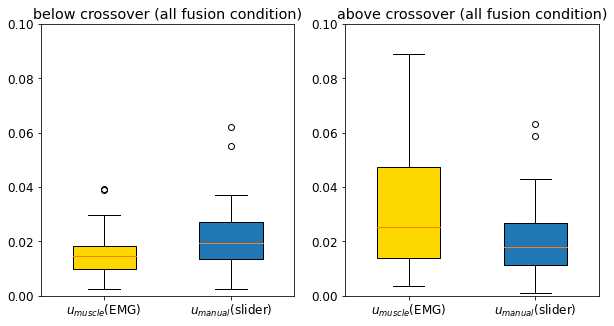

In [156]:
labels = [r'$u_{muscle}$(EMG)',r'$u_{manual}$(slider)']

# boxcolors = ['darkgrey','lightgrey','dimgrey']
fig,axs = plt.subplots(1, 2,figsize=(10,5)) 

# subplot 0
ax = axs[0]
boxcolors = ['gold',colors['BLUE']]
bplot = ax.boxplot([np.concatenate(U_emg_below),np.concatenate(U_slider_below)], widths = 0.5,patch_artist=True,labels=labels)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)

ax.title.set_text(r'below crossover (all fusion condition)')
# ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
ax.set_ylim(0,0.1)
    
# ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
# ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

# subplot 1
ax = axs[1]
boxcolors = ['gold',colors['BLUE']]
bplot = ax.boxplot([np.concatenate(U_emg_above),np.concatenate(U_slider_above)], widths = 0.5,patch_artist=True,labels=labels)
for patch, color in zip(bplot['boxes'], boxcolors):
    patch.set_facecolor(color)

ax.title.set_text(r'above crossover (all fusion condition)')
# ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
ax.set_ylim(0,0.1)

# ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
# ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

In [157]:
w, p = wilcoxon(np.concatenate(U_emg_below),np.concatenate(U_slider_below))
w,p

(326.0, 0.030651633140125)

In [158]:
w, p = wilcoxon(np.concatenate(U_emg_above),np.concatenate(U_slider_above))
w,p

(308.0, 0.018042631439243954)

## U_emg & U_slider every freq (all 3 fusion cond), 45 data points

In [224]:
last_trial = [4,4,4,4,4,4,4]

In [229]:
# u_emg & u_slider every freq of all participnats & mean of trials & all fusion conditions
U_emg_all = []
U_slider_all = []

for p in range(participants_num): 
    for c in [2,3,4]:
        #mean of all trials
        U_emg_all.append( np.mean(np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:])[:,stimulated_index]),axis=0) )
        U_slider_all.append( np.mean(np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:])[:,stimulated_index]),axis=0) )
            #take the absolute value of each complex number --> same as taking 2-norm of just one complex number

In [230]:
# # u_emg & u_slider every freq of all participnats & all trials & all fusion conditions
# U_emg_all = []
# U_slider_all = []

# for p in range(participants_num): 
#     for c in [2,3,4]:
#         for i in range(last_trial[c]): 
#             U_emg_all.append( np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][i][stimulated_index])) )
#             U_slider_all.append( np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:][i][stimulated_index])) )
#             #take the absolute value of each complex number --> same as taking 2-norm of just one complex number

In [1]:
# box plots
fig,ax = plt.subplots(1, 1,sharex=True,sharey=True,figsize=(15,8)) 
stim = np.array([1,2,3,4,5,6,7,8]) #number of stimulated freq = 8
pos_slider = stim + 0.15
pos_emg = stim - 0.15

U_emg_every_freq = [np.asarray(U_emg_all)[:,i] for i in range(8)]
U_slider_every_freq = [np.asarray(U_slider_all)[:,i] for i in range(8)]
bp0 = ax.boxplot(U_emg_every_freq, positions = pos_emg, widths = 0.2, patch_artist=True) # showfliers=False,
bp1 = ax.boxplot(U_slider_every_freq, positions = pos_slider, widths = 0.2,patch_artist=True)

boxcolors = ['gold',colors['BLUE']]
for patch in bp0['boxes']:
    patch.set_facecolor(boxcolors[0])
for patch in bp1['boxes']:
    patch.set_facecolor(boxcolors[1])

# make labels
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)
ax.set_xlim(0.5,8.5)
ax.set_xticks(stim)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_xlabel('stimulated frequencies (Hz)')
ax.set_ylabel(r'$|u_{muscle}|$ & $|u_{manual}|$')
# ax.title.set_text('MSE_freq')

# draw temporary lines and use them to create a legend
hr, = plt.plot([1,1],color = colors['r'])
hg, = plt.plot([1,1],color = colors['BLUE'])
plt.legend((hr, hg),('muscle','manual'), loc= 'upper left')
hr.set_visible(False)
hg.set_visible(False)

plt.ylim(-0.001,0.05)
plt.show();

NameError: name 'plt' is not defined

In [228]:
w, p = wilcoxon(U_emg_every_freq[1],U_slider_every_freq[1])
w,p

(33.0, 0.1353759765625)

## U_emg & U_slider every freq (sum of all 3 fusion cond)

In [10]:
last_trial = [4,4,4,4,4,4,4]

In [11]:
# u_emg & u_slider every freq of all participnats & mean of trials & all fusion conditions
U_emg_all = []
U_slider_all = []

for p in range(participants_num): 
    U_emg_cond = []
    U_slider_cond = []   
    for c in [2,3,4]:
        #mean of all trials
        U_emg_cond.append( np.mean(np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:])[:,stimulated_index]),axis=0) )
        U_slider_cond.append( np.mean(np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:])[:,stimulated_index]),axis=0) )
        #take the absolute value of each complex number --> same as taking 2-norm of just one complex number
    U_emg_all.append(np.sum(U_emg_cond,axis = 0))
    U_slider_all.append(np.sum(U_slider_cond,axis = 0))
    

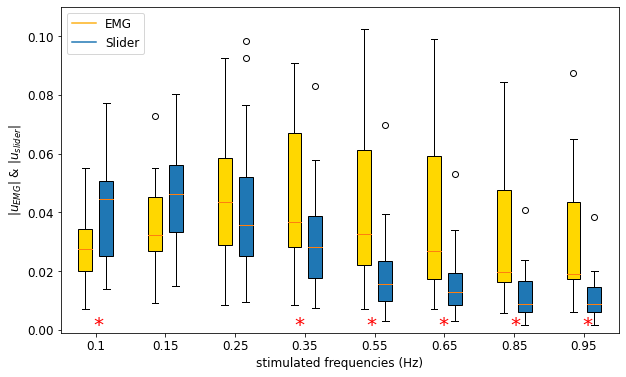

In [40]:
# box plots
fig,ax = plt.subplots(1, 1,sharex=True,sharey=True,figsize=(10,6)) 
stim = np.array([1,2,3,4,5,6,7,8]) #number of stimulated freq = 8
pos_slider = stim + 0.15
pos_emg = stim - 0.15

U_emg_every_freq = [np.asarray(U_emg_all)[:,i] for i in range(8)]
U_slider_every_freq = [np.asarray(U_slider_all)[:,i] for i in range(8)]
bp0 = ax.boxplot(U_emg_every_freq, positions = pos_emg, widths = 0.2, patch_artist=True) # showfliers=False,
bp1 = ax.boxplot(U_slider_every_freq, positions = pos_slider, widths = 0.2,patch_artist=True)

boxcolors = ['gold',colors['BLUE']]
for patch in bp0['boxes']:
    patch.set_facecolor(boxcolors[0])
for patch in bp1['boxes']:
    patch.set_facecolor(boxcolors[1])

# make labels
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)
ax.set_xlim(0.5,8.5)
ax.set_xticks(stim)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('stimulated frequencies (Hz)')
ax.set_ylabel(r'$|u_{EMG}|$ & $|u_{slider}|$')
# ax.title.set_text('MSE_freq')

# draw temporary lines and use them to create a legend
hr, = plt.plot([1,1],color = colors['r'])
hg, = plt.plot([1,1],color = colors['BLUE'])
plt.legend((hr, hg),('EMG','Slider'), loc= 'upper left')
hr.set_visible(False)
hg.set_visible(False)

# plt.axvspan(0.5,2.5, facecolor='green', alpha=0.2)
# plt.axvspan(2.5,7.5, facecolor='grey', alpha=0.1)
plt.text(0.17,0.13, r'*', fontsize=20, transform=plt.gcf().transFigure,color = 'red')
plt.text(0.45,0.13, r'*', fontsize=20, transform=plt.gcf().transFigure,color = 'red')
plt.text(0.55,0.13, r'*', fontsize=20, transform=plt.gcf().transFigure,color = 'red')
plt.text(0.65,0.13, r'*', fontsize=20, transform=plt.gcf().transFigure,color = 'red')
plt.text(0.75,0.13, r'*', fontsize=20, transform=plt.gcf().transFigure,color = 'red')
plt.text(0.85,0.13, r'*', fontsize=20, transform=plt.gcf().transFigure,color = 'red')


plt.ylim(-0.001,0.11)
plt.show();

In [13]:
w, p = wilcoxon(U_emg_every_freq[3],U_slider_every_freq[3])
w,p

(35.0, 0.1688232421875)

# 1-modality condition

## EMG-only & slider-only input at every stim freq

In [165]:
last_trial = [5,5,5,5,5,2,2]
# last_trial = [5,5,5,5,5,4,4]

In [166]:
# u_emg & u_slider every freq of all participnats & all trials 
U_emg_only = []
U_slider_only = []

for p in range(participants_num): 
    for c in [1,6]:
        # for i in range(last_trial[c]): 
        U_emg_only.append( np.mean(np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:])[:,stimulated_index]),axis=0) ) 
    for c in [0,5]:
        # for i in range(last_trial[c]): 
        U_slider_only.append( np.mean(np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:])[:,stimulated_index]),axis=0) )          
        #take the absolute value of each complex number --> same as taking 2-norm of just one complex number

In [167]:
# # u_emg & u_slider every freq of all participnats & all trials 
# U_emg_only = []
# U_slider_only = []

# for p in range(participants_num): 
#     for c in [1,6]:
#         for i in range(last_trial[c]): 
#             U_emg_only.append( np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:][i][stimulated_index])) ) 
#     for c in [0,5]:
#         for i in range(last_trial[c]): 
#             U_slider_only.append( np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:][i][stimulated_index])) )          
#         #take the absolute value of each complex number --> same as taking 2-norm of just one complex number

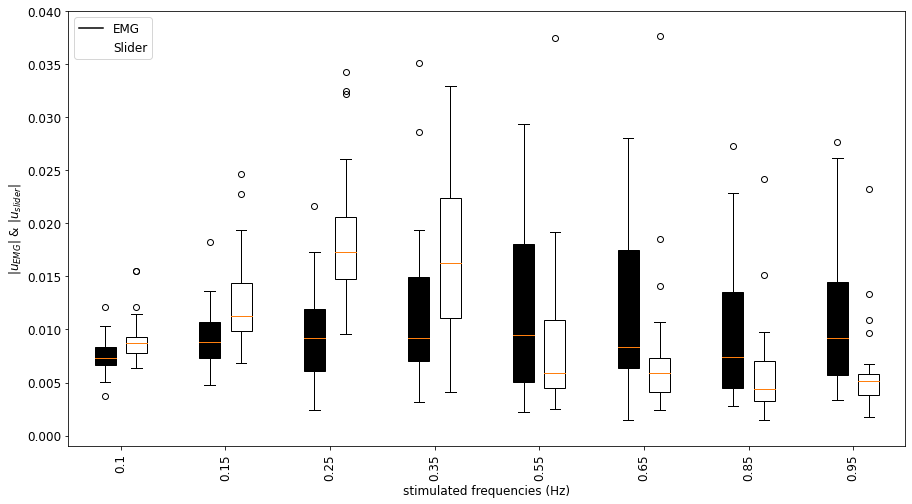

In [168]:
# box plots
fig,ax = plt.subplots(1, 1,sharex=True,sharey=True,figsize=(15,8)) 
stim = np.array([1,2,3,4,5,6,7,8]) #number of stimulated freq = 8
pos_slider = stim + 0.15
pos_emg = stim - 0.15

U_emg_every_freq = [np.asarray(U_emg_only)[:,i] for i in range(8)]
U_slider_every_freq = [np.asarray(U_slider_only)[:,i] for i in range(8)]
bp0 = ax.boxplot(U_emg_every_freq, positions = pos_emg, widths = 0.2, patch_artist=True)
bp1 = ax.boxplot(U_slider_every_freq, positions = pos_slider, widths = 0.2, patch_artist=True)

boxcolors = ['black','white']
for patch in bp0['boxes']:
    patch.set_facecolor(boxcolors[0])
for patch in bp1['boxes']:
    patch.set_facecolor(boxcolors[1])

# make labels
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)
ax.set_xlim(0.5,8.5)
ax.set_xticks(stim)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_xlabel('stimulated frequencies (Hz)')
ax.set_ylabel(r'$|u_{EMG}|$ & $|u_{slider}|$')
# ax.title.set_text('MSE_freq')

# draw temporary lines and use them to create a legend
hr, = plt.plot([1,1],color = 'black')
hg, = plt.plot([1,1],color = 'white')
plt.legend((hr, hg),('EMG','Slider'), loc= 'upper left')
hr.set_visible(False)
hg.set_visible(False)

plt.ylim(-0.001,0.04)
plt.show();

In [141]:
w, p = wilcoxon(U_emg_every_freq[4],U_slider_every_freq[4])
w,p

(121.0, 0.02182672159602272)

## inversion error at every freq

In [169]:
# u_emg & u_slider every freq of all participnats & all trials 
FW_emg = []
FW_slider = []
for p in range(participants_num): 
    FW_emg_only = []
    FW_slider_only = [] 
    for c in [1,6]:
        for i in range(last_trial[c]//2): 
            FW_emg_only.append( np.abs(TF['F']['subject'+str(p)]['condition'+str(c)][-(last_trial[c]//2):][i] - 1/M_h[stimulated_index]) ) 
    for c in [0,5]:
        for i in range(last_trial[c]//2): 
            FW_slider_only.append( np.abs(TF['F']['subject'+str(p)]['condition'+str(c)][-(last_trial[c]//2):][i] - 1/M_h[stimulated_index]) )          
    FW_emg.append( np.mean(FW_emg_only,axis =0) )  #mean of all trials from contorl 1 & 2
    FW_slider.append( np.mean(FW_slider_only,axis =0) )


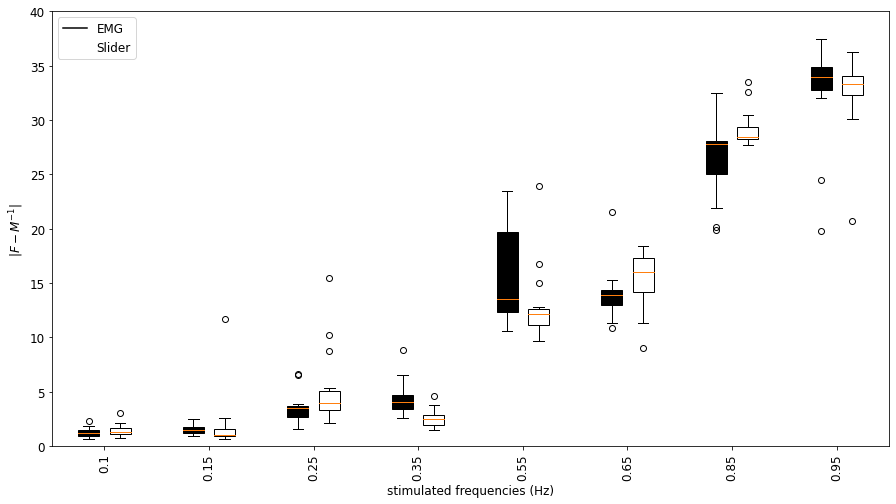

In [171]:
# box plots
fig,ax = plt.subplots(1, 1,sharex=True,sharey=True,figsize=(15,8)) 
stim = np.array([1,2,3,4,5,6,7,8]) #number of stimulated freq = 8
pos_slider = stim + 0.15
pos_emg = stim - 0.15

FW_emg_every_freq = [np.asarray(FW_emg)[:,i] for i in range(8)]
FW_slider_every_freq = [np.asarray(FW_slider)[:,i] for i in range(8)]
bp0 = ax.boxplot(FW_emg_every_freq, positions = pos_emg, widths = 0.2, patch_artist=True)
bp1 = ax.boxplot(FW_slider_every_freq, positions = pos_slider, widths = 0.2, patch_artist=True)

boxcolors = ['black','white']
for patch in bp0['boxes']:
    patch.set_facecolor(boxcolors[0])
for patch in bp1['boxes']:
    patch.set_facecolor(boxcolors[1])

# make labels
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)
ax.set_xlim(0.5,8.5)
ax.set_xticks(stim)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_xlabel('stimulated frequencies (Hz)')
ax.set_ylabel(r'$|F-M^{-1}|$')
# ax.title.set_text('MSE_freq')

# draw temporary lines and use them to create a legend
hr, = plt.plot([1,1],color = 'black')
hg, = plt.plot([1,1],color = 'white')
plt.legend((hr, hg),('EMG','Slider'), loc= 'upper left')
hr.set_visible(False)
hg.set_visible(False)

plt.ylim(-0.001,40)
plt.show();

In [182]:
w, p = wilcoxon(FW_emg_every_freq[6],FW_slider_every_freq[6])
w,p

(23.0, 0.03533935546875)

## stats functions

In [ ]:
# Wilcoxon signed-rank test:  tests the null hypothesis that two related paired samples come from the same distribution

def WilcoxonTest(all_data):
    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = wilcoxon(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag

In [ ]:
#T-test: test for the null hypothesis that two related or repeated samples have identical average (expected) values
def TTest(all_data):
    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = ttest_rel(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag

In [ ]:
# number of trials to look at of each condition: (ex: last 4)
# last_trial = [4,4,8,8,8,4,4]
# last_trial = [2,2,4,4,4,2,2]
# last_trial = [2,2,2,2,2,2,2]
# last_trial = [8,8,10,10,10,2,2]
# last_trial = [5,5,5,5,5,4,4]
last_trial = [5,5,5,5,5,2,2]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
# first_freq = [0,1,2,3,4,5,6,7]
first_freq = [0,1]

# plot_title = 'first 2 freqs' #'all freqs'